In [90]:
# TODO scrape any car data from ss.com
# clean up prices as numerics
# group by make and model
# plot the data - pricing for sure

In [91]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [92]:
url = "https://www.ss.com/en/transport/cars/bmw/sell/"

In [93]:
req = requests.get(url)
req.status_code

200

In [94]:
soup = BeautifulSoup(req.text, 'lxml')
soup.title

<title>SS.COM Cars - BMW, Prices, Sell - Advertisements</title>

In [95]:
tables = soup.find_all("table")
headline = soup.find("tr", {"id":"head_line"})
headtds = headline.find_all("td")
headline.text
headtds[0].text

'\n\xa0Advertisements\r\n\n\n\ndate\n'

In [96]:
headcolumns = [el.text for el in headtds[1:]]
headcolumns

['Model', 'Year', 'Volume', 'Run', 'Price']

In [97]:
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [98]:
column_names = getColList(soup)
column_names

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [99]:
trows = soup.find_all('tr')

In [100]:
rows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]

In [101]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [102]:
rows = getRowList(soup)

In [103]:
first_ad = rows[0]

In [104]:
row_tds = first_ad.find_all('td')

In [105]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [106]:
getRow(rows[6])

{'description': 'BMW 320 2.0l automātiskā ātrumkārba. \r\nPraktiski perfektā tehniskā un vizuāl',
 'url': 'https://ss.com/msg/en/transport/cars/bmw/320/blefhc.html',
 'Model': '320',
 'Year': '2010',
 'Volume': '2.0D',
 'Run': '284 thd.',
 'Price': '7,800  €'}

In [107]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [108]:
def getDFfromURL(url):
    
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None 
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

In [109]:
cars_bmw = url
idf = getDFfromURL(cars_bmw)
idf.head()

,description,url,Model,Year,Volume,Run,Price
0,"X-Drive 2.0D 110Kw Model Advantage, Harmann ka...",https://ss.com/msg/en/transport/cars/bmw/x1/bf...,X1,2017,2.0D,187 thd.,"19,950 €"
1,Auto īpašnieks pārdod savu BMW X5 3.0d 160kw S...,https://ss.com/msg/en/transport/cars/bmw/x5/bk...,X5,2005,3.0D,235 thd.,"5,250 €"
2,Active Tourer 216 модель 2017 года / Автомобил...,https://ss.com/msg/en/transport/cars/bmw/216/b...,216,2017,1.5D,160 thd.,"10,250 €"
3,Pārdodu BMW E46 Special Edition. Facelift. 200...,https://ss.com/msg/en/transport/cars/bmw/320/b...,320,2004,2.0D,220 thd.,"3,400 €"
4,Pārdod BMW 320d\r\nAuto ir ļoti labā stāvoklī\...,https://ss.com/msg/en/transport/cars/bmw/320/b...,320,2006,2.0D,328 thd.,"4,500 €"


In [110]:
idf.to_csv("cars_bmw_20221023.csv")

In [120]:
bmw_df = pd.read_csv(r"C:\Users\dovil\Desktop\she goes tech\SGT\cars_bmw_20221023.csv")


In [121]:
bmw_df['Price'] = bmw_df['Price'].str.replace("€","")
bmw_df['Price'] = bmw_df['Price'].str.replace(",","")
bmw_df.Price.head()
bmw_df['Price'] = pd.to_numeric(bmw_df['Price'], errors='coerce')

pd.options.display.float_format = '{:,.2f}'.format
bmw_df['Price'].describe()

count       60.00
mean     7,710.60
std      7,593.73
min      1,490.00
25%      3,490.00
50%      4,875.00
75%      9,637.50
max     50,000.00
Name: Price, dtype: float64

In [122]:
bmw_df.groupby(['Year']).describe()['Price']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1984,1.00,"3,650.00",NaN,"3,650.00","3,650.00","3,650.00","3,650.00","3,650.00"
1990,1.00,"2,500.00",NaN,"2,500.00","2,500.00","2,500.00","2,500.00","2,500.00"
1993,1.00,"4,100.00",NaN,"4,100.00","4,100.00","4,100.00","4,100.00","4,100.00"
1995,1.00,"3,600.00",NaN,"3,600.00","3,600.00","3,600.00","3,600.00","3,600.00"
1999,1.00,"1,490.00",NaN,"1,490.00","1,490.00","1,490.00","1,490.00","1,490.00"
2000,1.00,"3,990.00",NaN,"3,990.00","3,990.00","3,990.00","3,990.00","3,990.00"
2002,6.00,"2,986.50",634.87,"2,250.00","2,542.50","2,949.50","3,267.25","3,990.00"
2003,3.00,"3,310.00",311.77,"2,950.00","3,220.00","3,490.00","3,490.00","3,490.00"
2004,7.00,"3,997.00","2,547.68","1,999.00","2,550.00","3,400.00","3,990.00","9,500.00"


In [123]:
bmw_df['Run'] = bmw_df['Run'].str.replace("thd.","")
bmw_df['Run'] = pd.to_numeric(bmw_df['Run'], errors='coerce')
bmw_df.groupby(['Year']).describe()['Run']

C:\Users\dovil\AppData\Local\Temp\ipykernel_13584\1456715884.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  bmw_df['Run'] = bmw_df['Run'].str.replace("thd.","")


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1984,1.00,200.00,NaN,200.00,200.00,200.00,200.00,200.00
1990,1.00,286.00,NaN,286.00,286.00,286.00,286.00,286.00
1993,1.00,318.00,NaN,318.00,318.00,318.00,318.00,318.00
1995,1.00,321.00,NaN,321.00,321.00,321.00,321.00,321.00
1999,1.00,321.00,NaN,321.00,321.00,321.00,321.00,321.00
2000,1.00,206.00,NaN,206.00,206.00,206.00,206.00,206.00
2002,4.00,322.25,154.91,151.00,236.50,310.00,395.75,518.00
2003,2.00,305.00,106.07,230.00,267.50,305.00,342.50,380.00
2004,6.00,296.33,100.94,131.00,244.75,334.50,357.50,398.00


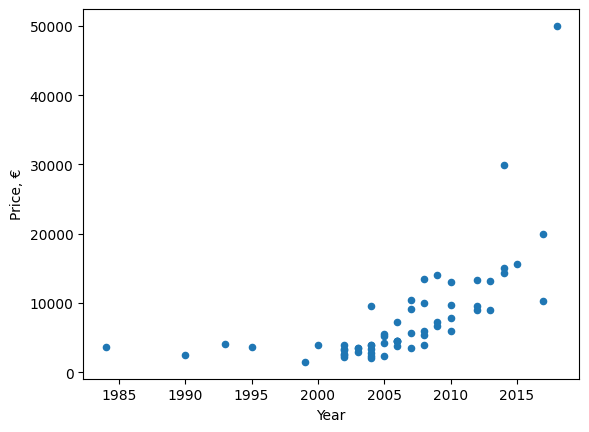

In [124]:

bmw_df_price = bmw_df.sort_values(['Year'], ascending=[True])
bmw_df_price = pd.DataFrame(bmw_df_price,columns=['Year','Price'])
bmw_df_price.plot(x ='Year', y='Price', kind = 'scatter')
plt.ylabel('Price, \u20ac')
plt.show()


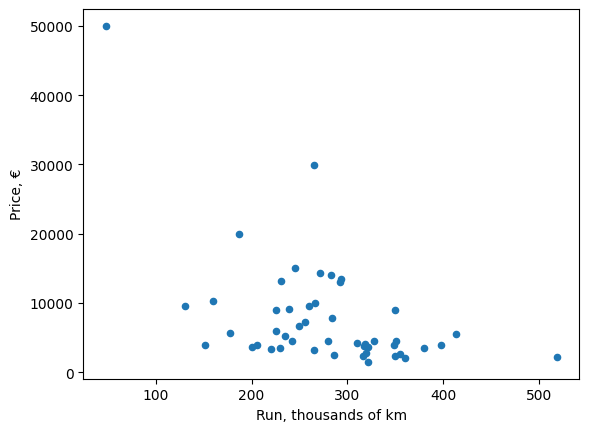

In [125]:
bmw_df_run = bmw_df.sort_values(['Run'], ascending=[True])
bmw_df_run = pd.DataFrame(bmw_df_run,columns=['Run','Price'])
bmw_df_run.plot(x ='Run', y='Price', kind = 'scatter')
plt.xlabel('Run, thousands of km')
plt.ylabel('Price, \u20ac')
plt.show()

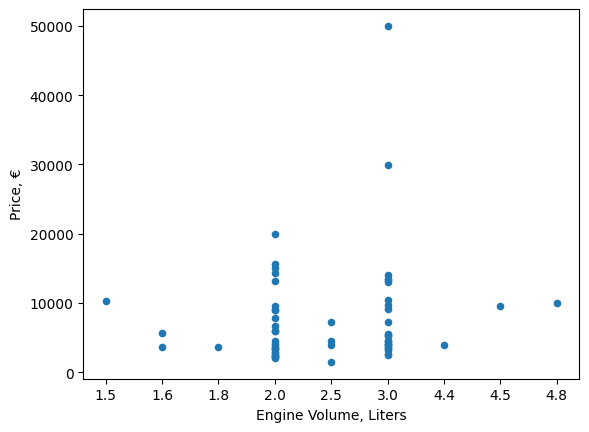

In [126]:
bmw_df['Volume'] = bmw_df['Volume'].str.replace("D","")
bmw_df['Volume'] = bmw_df['Volume'].str.replace("B","")
bmw_df['Volume'] = bmw_df['Volume'].str.replace("H","")
bmw_df_volume = bmw_df.sort_values(['Volume'], ascending=[True])
bmw_df_volume = pd.DataFrame(bmw_df_volume,columns=['Volume','Price'])
bmw_df_volume.plot(x ='Volume', y='Price', kind = 'scatter')
plt.ylabel('Price, \u20ac')
plt.xlabel('Engine Volume, Liters')
plt.show()

Text(0.5, 1.0, 'The median car price, €')

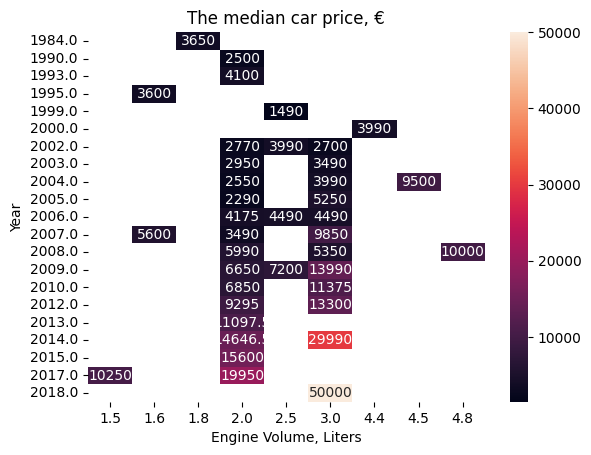

In [127]:
bmw_map = bmw_df[['Year', 'Volume', 'Run', 'Price', 'Model']]
bmw_map = bmw_map.astype({'Year':'float'})

bmw_table = bmw_map.pivot_table(index='Year', columns='Volume', values='Price', aggfunc=np.median)
bmw_table

bmw_table.style.background_gradient(cmap='summer')
ax = sns.heatmap(data=bmw_table, c, annot=True, fmt='g')

ax.set_xlabel('Engine Volume, Liters')
ax.set_title('The median car price, \u20ac')

Text(0.5, 1.0, 'The median car price, €')

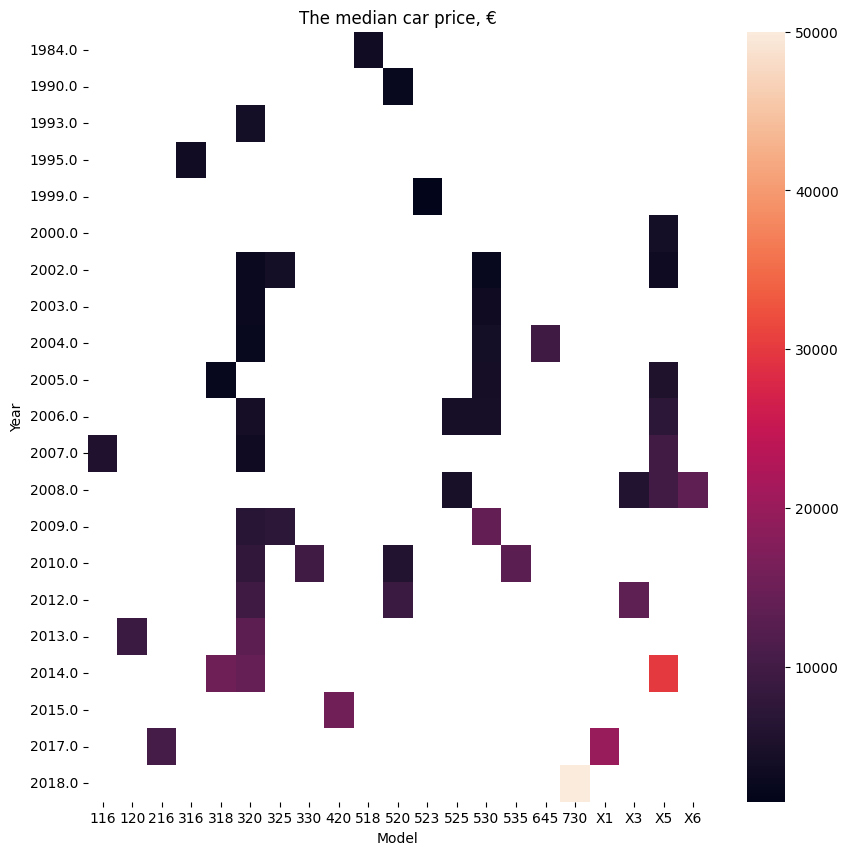

In [119]:

bmw_table = bmw_map.pivot_table(index='Year', columns='Model', values='Price', aggfunc=np.median)
bmw_table
plt.figure(figsize=(10,10))
bmw_table.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True)).highlight_max('red')
ax = sns.heatmap(data=bmw_table)
ax.set_xlabel('Model')
ax.set_title('The median car price, \u20ac')